In [1]:
import torch 
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from pathlib import Path
import csv
import numpy as np
import cv2
from tqdm import tqdm

from edge_detection import edgeDetection
from interest_point_detection import display_interest_points_matrix
from detect_laser import *
from torchinfo import summary
import torchmetrics

import matplotlib.pyplot as plt
from torchviz import make_dot


In [2]:
# Prepare data 

data_path = Path("./data")
csv_list = list(data_path.glob("*.csv"))
file_map = dict()
test_map = dict()
i = 0
l = 0
for csv_file in csv_list:   
    with open(csv_file, newline='') as csvfile:

        reader = csv.reader(csvfile, delimiter=',')

        header = next(reader)

        # First 3 of every file will be for testing
        for k in range(3):
            row = next(reader)
            if len(row) > 0:
                test_map[l] = dict()
                test_map[l]["name"] = row[0]
                
                for j in range(1, 3):
                    test_map[l][header[j]] = row[j]

                l+=1
        
        for row in reader:
        
            if len(row) > 0:
                file_map[i] = dict()
                file_map[i]["name"] = row[0]
                
                for j in range(1, 3):
                    file_map[i][header[j]] = row[j]

                i+=1

In [3]:
# Create the mask using both laser calibrations

calib1 = Path("old_configs/calibration-output.dat")
lcalib1 = Path("old_configs/laser-calibration-output-4-12-bot.dat")

calib2 = Path("old_configs/fsl-01d-lens.dat")
lcalib2 = Path("old_configs/laser-calibration-output-7-13.dat")

calib3 = Path("old_configs/fsl-01d-lens-raw.dat")
lcalib3 = Path("old_configs/laser-calibration-output-7-13.dat")

shape = (3000, 4000)
mask1 = get_mask(lcalib1, calib1, shape)
mask2 = get_mask(lcalib2, calib2, shape)
# mask3 = get_mask(lcalib3, calib3, shape)

fat_mask = return_mask_stack([mask1, mask2])

# cv2.namedWindow("img", cv2.WINDOW_NORMAL)
# cv2.imshow("img", fat_mask*255)
# cv2.waitKey(0)
# cv2.destroyAllWindows()   

In [4]:
# for i in range(350):
#     img = cv2.imread(file_map[i]["name"])
#     img = img[:3000,:4000,:]
#     img = get_masked_image_with_mask(img, fat_mask)
#     hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV) 
#     # set lower and upper color limits
#     lower_val = np.array([0,0,200])
#     upper_val = np.array([255,50,255])
#     # Threshold the HSV image 
#     mask = cv2.inRange(hsv, lower_val, upper_val)
#     # remove noise
#     kernel =  np.ones((5,5),np.uint8)
#     mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
#     # find contours in mask
#     contours, hierarchy = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
#     # draw contours
#     for cnt in contours:
#         cv2.drawContours(img,[cnt],0,(0,0,255),thickness=-1)
#     #show image

#     cv2.namedWindow("img", cv2.WINDOW_NORMAL)
#     cv2.imshow("img", img)
#     cv2.waitKey(0)
#     cv2.destroyAllWindows()    

In [5]:
# for i in range(350):
#     img = cv2.imread(file_map[i]["name"])
#     img = img[:3000,:4000,:]
#     img = get_masked_image_with_mask(img, fat_mask)

#     interest_points = display_interest_points_matrix(img)

#     cv2.namedWindow("img", cv2.WINDOW_NORMAL)
#     cv2.imshow("img", img)
#     cv2.waitKey(0)
#     cv2.destroyAllWindows()    

In [6]:
# Check to make sure everything is working with the data loading
for i in test_map:
    
    print(f"{i}: {test_map[i]['name']} has laser at coordinates ({test_map[i]['laser.x']}, {test_map[i]['laser.y']})")

for i in file_map:
    print(f"{i}: {file_map[i]['name']} has laser at coordinates ({file_map[i]['laser.x']}, {file_map[i]['laser.y']})")

0: data/FSL-01D Box-rectified/P7130208.JPG has laser at coordinates (1964, 1472)
1: data/FSL-01D Box-rectified/P7130222.JPG has laser at coordinates (1942, 1391)
2: data/FSL-01D Box-rectified/P7130212.JPG has laser at coordinates (1973, 1494)
3: data/FSL-01D George Measurements-rectified/P7250414.JPG has laser at coordinates (1813, 976)
4: data/FSL-01D George Measurements-rectified/P7250436.JPG has laser at coordinates (1963, 1464)
5: data/FSL-01D George Measurements-rectified/P7250444.JPG has laser at coordinates (1926, 1342)
6: data/Green laser calibration-rectified/P7250177.JPG has laser at coordinates (2040, 1442)
7: data/Green laser calibration-rectified/P7250195.JPG has laser at coordinates (1933, 1103)
8: data/Green laser calibration-rectified/P7250165.JPG has laser at coordinates (2013, 1358)
9: data/Green Laser Test-rectified/P7170009.JPG has laser at coordinates (2060, 1424)
10: data/Green Laser Test-rectified/P7170012.JPG has laser at coordinates (2064, 1452)
11: data/Green 

In [7]:
class LaserDetectionDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, file_map, fat_mask):
        """
        Arguments:
            file_map (string): map of all laser positions
        """
        self.file_map = file_map
        self.fat_mask = fat_mask

    def __len__(self):

        return len(self.file_map)

    def __getitem__(self, idx):

        file_name = self.file_map[idx]["name"]
        laser_x = int(self.file_map[idx]["laser.x"])
        laser_y = int(self.file_map[idx]["laser.y"])

        laser_coords = np.array([laser_x, laser_y]).astype(np.float32)


        img = cv2.imread(file_name)
        img = img[:3000,:4000,:]
        masked_image = get_masked_image_with_mask(img, self.fat_mask)

        # hsv = cv2.cvtColor(masked_image, cv2.COLOR_BGR2HSV) 
        # # set lower and upper color limits
        # lower_val = np.array([0,0,200])
        # upper_val = np.array([255,50,255])
        # # Threshold the HSV image 
        # mask = cv2.inRange(hsv, lower_val, upper_val)
        # # remove noise
        # kernel =  np.ones((5,5),np.uint8)
        # mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
        # # find contours in mask
        # contours, hierarchy = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        # # draw contours
        # for cnt in contours:
        #     cv2.drawContours(masked_image,[cnt],0,(0,0,255),thickness=-1)

        float_img = masked_image[0:1700, 1200:2300,:].astype(np.float32)
        output_img = np.reshape(float_img, (3, 1700, 1100))
        return output_img, laser_coords

In [8]:
# laser_dataset = LaserDetectionDataset(file_map = file_map, fat_mask=fat_mask)
# laser_dataloader = DataLoader(laser_dataset)

# for i, sample in tqdm(enumerate(laser_dataloader)):

#     resized_img, laser_coords = sample
#     laser_np = (laser_coords.numpy()[0][0]-1200, laser_coords.numpy()[0][1])
#     print(laser_np)

#     display = np.reshape(resized_img.numpy(), (1700, 1100, 3))

#     # print(laser_np)
#     cv2.circle(display, center=laser_np, radius = 20, thickness=10, color=(0,0,255))
    
#     # cv2.namedWindow("burer", cv2.WINDOW_NORMAL)
#     plt.imshow(display, )
#     # cv2.waitKey(0)
#     # cv2.destroyAllWindows()

#     break
    

In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, kernel_size=(3,3), stride=1, padding=1)
        self.act1 = nn.ReLU()
        self.drop1 = nn.Dropout(0.3)
        self.pool1 = nn.AvgPool2d(kernel_size=(3, 3))

        self.conv2 = nn.Conv2d(8, 2, kernel_size=(3,3), stride=1, padding=1)
        self.act2 = nn.ReLU()
        self.drop2 = nn.Dropout(0.3)
        self.pool2 = nn.AvgPool2d(kernel_size=(3, 3))
        
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(45872, 100)
        self.act3 = nn.ReLU()

        self.linear2 = nn.Linear(100, 10)
        self.act4 = nn.ReLU()
        self.linear3 = nn.Linear(10, 2)

    def forward(self, x):
        x = self.act1(self.conv1(x))
        x = self.pool1(x)
        x = self.drop1(x)

        x = self.act2(self.conv2(x))
        x = self.pool2(x)
        x = self.drop2(x)
        
        x = self.flatten(x)
        x = self.act3(self.linear1(x))

        x = self.act4(self.linear2(x))
        x = self.linear3(x)
        
        return x

In [10]:
model = Net()
batch_size = 1
summary(model, input_size=(batch_size, 3, 1700, 1100), device="cuda")
# make_dot(0, params=dict(list(model.named_parameters()))).render("rnn_torchviz", format="png")

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [1, 2]                    --
├─Conv2d: 1-1                            [1, 8, 1700, 1100]        224
├─ReLU: 1-2                              [1, 8, 1700, 1100]        --
├─AvgPool2d: 1-3                         [1, 8, 566, 366]          --
├─Dropout: 1-4                           [1, 8, 566, 366]          --
├─Conv2d: 1-5                            [1, 2, 566, 366]          146
├─ReLU: 1-6                              [1, 2, 566, 366]          --
├─AvgPool2d: 1-7                         [1, 2, 188, 122]          --
├─Dropout: 1-8                           [1, 2, 188, 122]          --
├─Flatten: 1-9                           [1, 45872]                --
├─Linear: 1-10                           [1, 100]                  4,587,300
├─ReLU: 1-11                             [1, 100]                  --
├─Linear: 1-12                           [1, 10]                   1,010
├─R

In [12]:
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)

laser_dataset = LaserDetectionDataset(file_map = file_map, fat_mask=fat_mask)
laser_dataloader = DataLoader(laser_dataset)

test_dataset = LaserDetectionDataset(file_map = test_map, fat_mask=fat_mask)
test_dataloader = DataLoader(test_dataset)

# load_path = Path("model29.pth")
# model.load_state_dict(torch.load(load_path.as_posix()))

In [14]:
n_epochs = 100
for epoch in range(0, n_epochs):
    acc = 0
    count = 1
    for inputs, labels in tqdm(laser_dataloader):

        inputs = inputs.to('cuda')
        labels = labels.to('cuda')
        
        y_pred = model(inputs)
        make_dot(y_pred.mean(), params=dict(model.named_parameters()),show_saved=True)
        break
    break
    #     exit(0)
    #     count += 1
    #     acc += torch.norm(y_pred-labels)
        
    #     loss = loss_fn(y_pred, labels)
    #     optimizer.zero_grad()
    #     loss.backward()
    #     optimizer.step()

    # test_acc = 0
    # test_count = 1
    
    # for test_inputs, test_labels in tqdm(test_dataloader):
        
    #     test_inputs = test_inputs.to('cuda')
    #     test_labels = test_labels.to('cuda')
    #     test_pred = model(test_inputs)
    #     test_count += 1
    #     test_acc += torch.norm(test_pred-test_labels)
        
    # print(f"Epoch {epoch}: training error: {acc/count}")
    # print(f"Epoch {epoch}: test error: {test_acc/test_count}")

    # if ((epoch+1) % 10 == 0):
    #     torch.save(model.state_dict(), f"model_plain_image{epoch}.pth")



  0%|                                                                                                                                      | 0/314 [00:00<?, ?it/s]


In [44]:
torch.cuda.is_available()
torch.cuda.current_device()
torch.cuda.get_device_name(0)

'NVIDIA RTX A6000'

0it [00:00, ?it/s]

Prediction is:  (905, 1596)
Actual is:  (764, 1472)


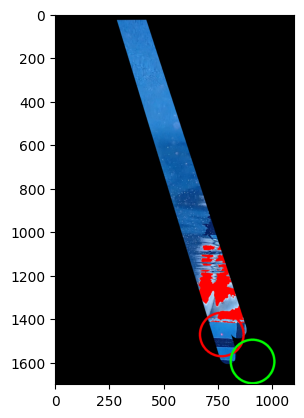

1it [00:02,  2.59s/it]

Prediction is:  (930, 1626)
Actual is:  (742, 1391)


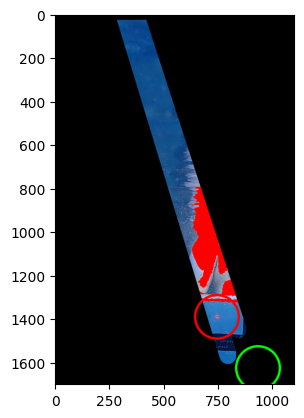

2it [00:03,  1.41s/it]

Prediction is:  (926, 1607)
Actual is:  (773, 1494)


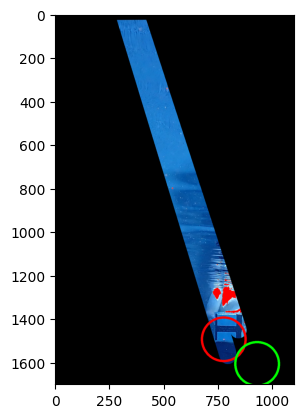

3it [00:03,  1.01it/s]

Prediction is:  (920, 1612)
Actual is:  (613, 976)


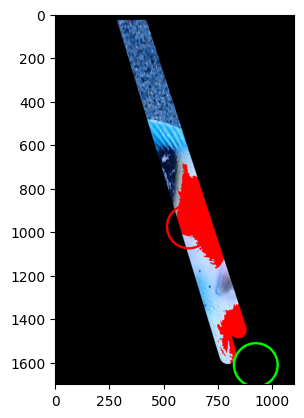

4it [00:04,  1.24it/s]

Prediction is:  (908, 1595)
Actual is:  (763, 1464)


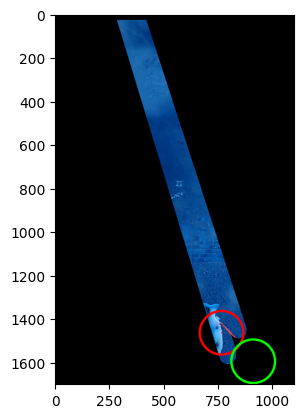

5it [00:04,  1.46it/s]

Prediction is:  (903, 1612)
Actual is:  (726, 1342)


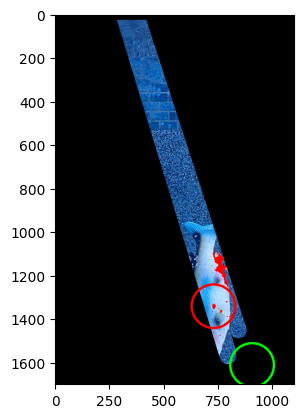

6it [00:05,  1.62it/s]

Prediction is:  (898, 1590)
Actual is:  (840, 1442)


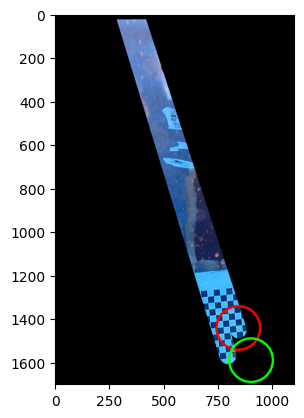

7it [00:05,  1.67it/s]

Prediction is:  (940, 1618)
Actual is:  (733, 1103)


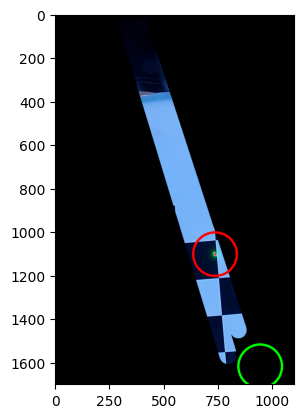

8it [00:06,  1.78it/s]

Prediction is:  (908, 1602)
Actual is:  (813, 1358)


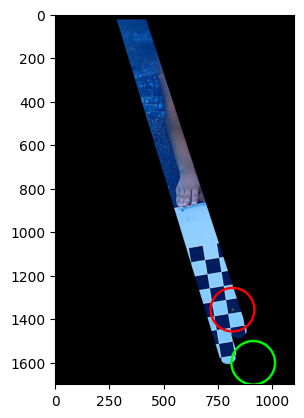

9it [00:06,  1.87it/s]

Prediction is:  (901, 1592)
Actual is:  (860, 1424)


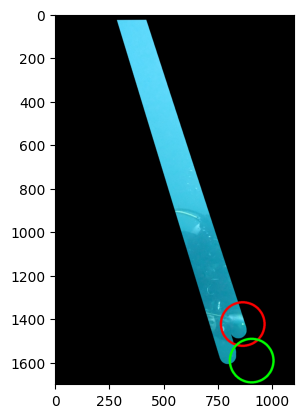

10it [00:07,  1.95it/s]

Prediction is:  (879, 1583)
Actual is:  (864, 1452)


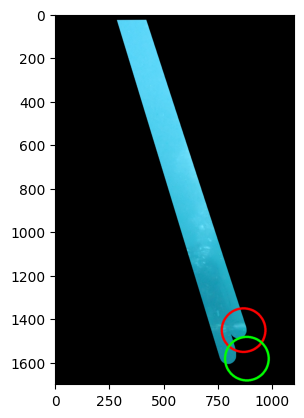

11it [00:07,  2.04it/s]

Prediction is:  (958, 1629)
Actual is:  (863, 1445)


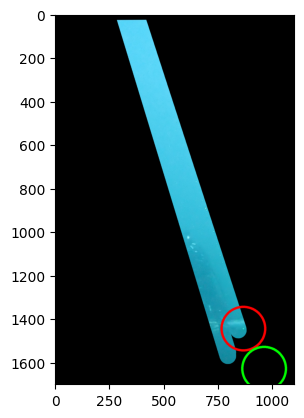

12it [00:08,  2.11it/s]

Prediction is:  (904, 1583)
Actual is:  (823, 1403)


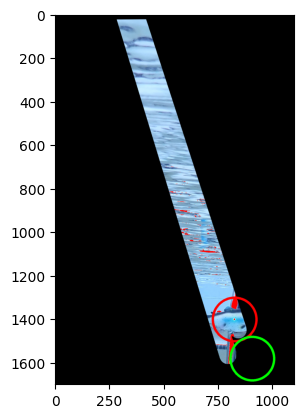

13it [00:08,  2.17it/s]

Prediction is:  (943, 1624)
Actual is:  (759, 1198)


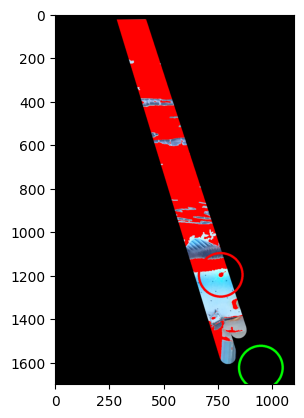

14it [00:09,  1.80it/s]

Prediction is:  (934, 1608)
Actual is:  (833, 1444)


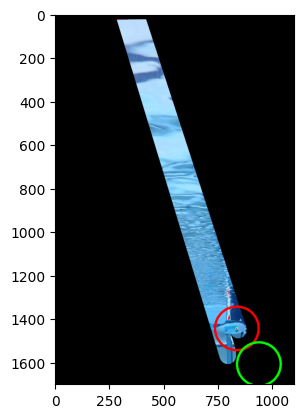

15it [00:10,  1.45it/s]

Prediction is:  (888, 1579)
Actual is:  (836, 1437)


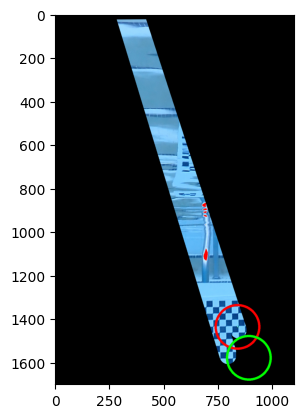

16it [00:11,  1.36it/s]

Prediction is:  (932, 1616)
Actual is:  (833, 1428)


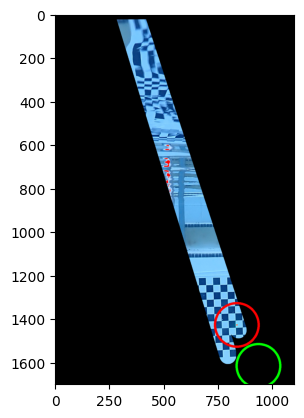

17it [00:12,  1.17it/s]

Prediction is:  (945, 1619)
Actual is:  (825, 1402)


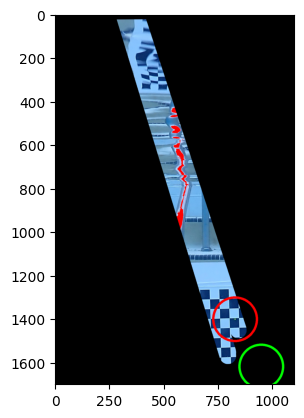

18it [00:13,  1.14it/s]

Prediction is:  (922, 1602)
Actual is:  (776, 1476)


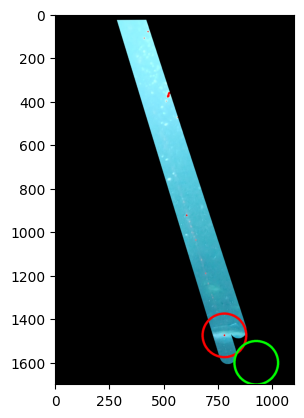

19it [00:14,  1.13it/s]

Prediction is:  (911, 1601)
Actual is:  (770, 1464)


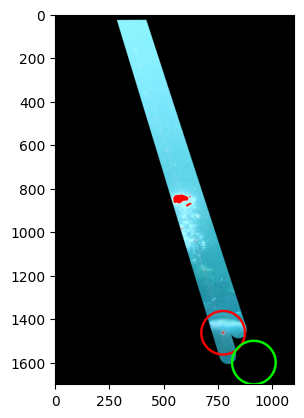

20it [00:14,  1.10it/s]

Prediction is:  (904, 1605)
Actual is:  (760, 1423)


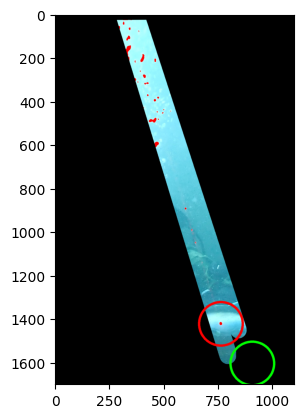

21it [00:15,  1.20it/s]

Prediction is:  (915, 1610)
Actual is:  (753, 1429)


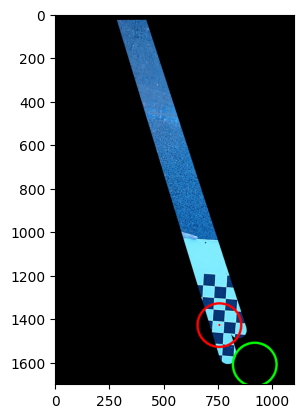

22it [00:16,  1.38it/s]

Prediction is:  (878, 1581)
Actual is:  (765, 1459)


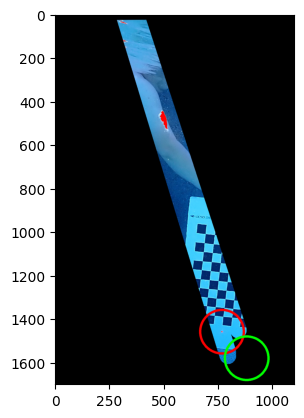

23it [00:16,  1.38it/s]

Prediction is:  (933, 1633)
Actual is:  (767, 1466)


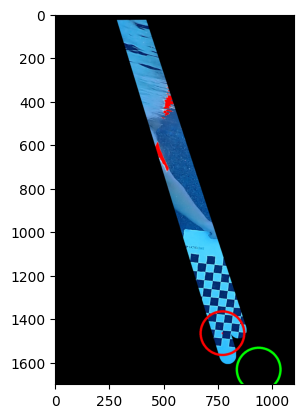

24it [00:18,  1.10it/s]

Prediction is:  (906, 1607)
Actual is:  (769, 1475)


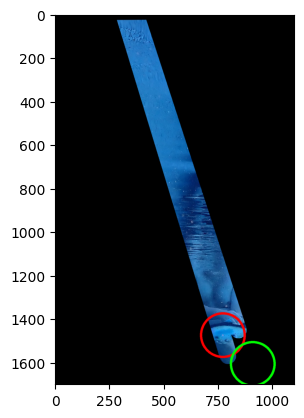

25it [00:18,  1.16it/s]

Prediction is:  (892, 1581)
Actual is:  (750, 1419)


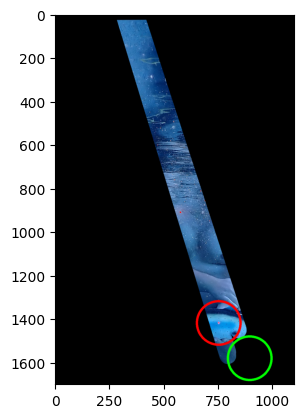

26it [00:19,  1.22it/s]

Prediction is:  (895, 1594)
Actual is:  (740, 1388)


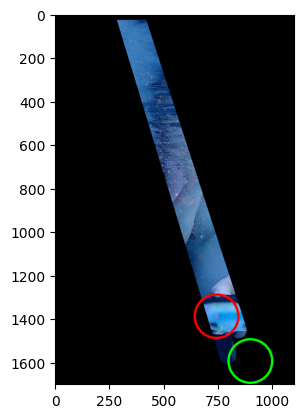

27it [00:20,  1.39it/s]

Prediction is:  (925, 1608)
Actual is:  (703, 1242)


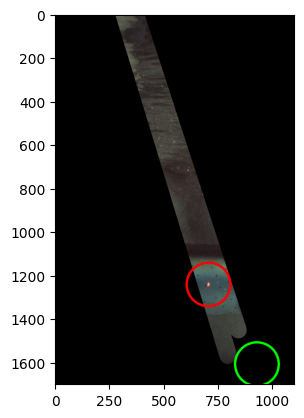

28it [00:20,  1.46it/s]

Prediction is:  (930, 1605)
Actual is:  (776, 1482)


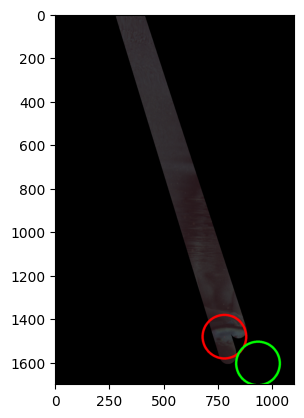

29it [00:21,  1.54it/s]

Prediction is:  (919, 1600)
Actual is:  (736, 1354)


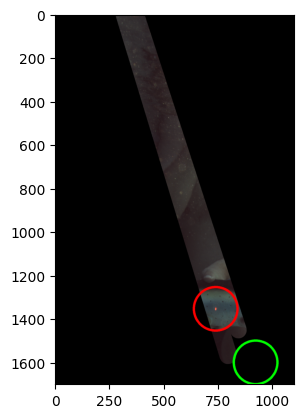

30it [00:21,  1.61it/s]

Prediction is:  (902, 1585)
Actual is:  (739, 1351)


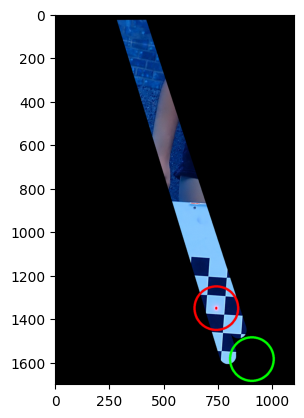

31it [00:22,  1.70it/s]

Prediction is:  (916, 1602)
Actual is:  (769, 1446)


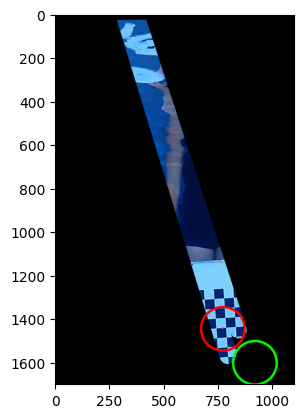

32it [00:22,  1.75it/s]

Prediction is:  (928, 1616)
Actual is:  (762, 1425)


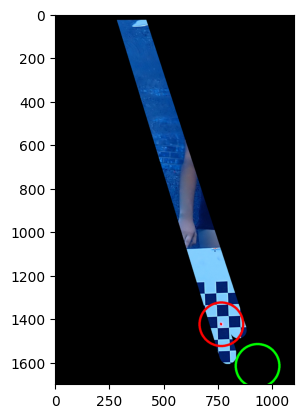

33it [00:23,  1.86it/s]

Prediction is:  (921, 1612)
Actual is:  (766, 1454)


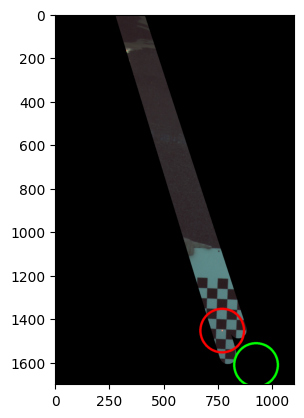

34it [00:23,  1.82it/s]

Prediction is:  (875, 1580)
Actual is:  (755, 1413)


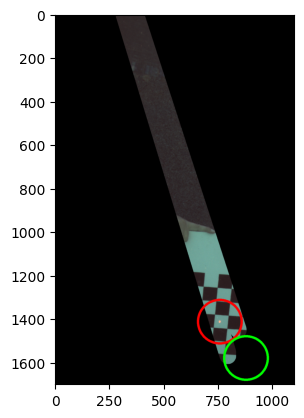

35it [00:24,  1.86it/s]

Prediction is:  (927, 1616)
Actual is:  (775, 1480)


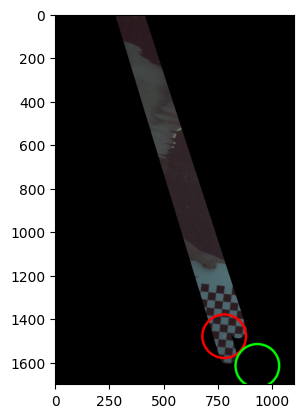

36it [00:24,  1.44it/s]


In [14]:
for i, sample in tqdm(enumerate(test_dataloader)):

    resized_img, laser_coords = sample
    laser_np = (laser_coords.numpy()[0][0].astype(np.uint16)-1200, laser_coords.numpy().astype(np.uint16)[0][1])

    y_pred = model(inputs).to('cpu')
    laser_pred = (y_pred.detach().numpy()[0][0].astype(np.uint16)-1200, y_pred.detach().numpy()[0][1].astype(np.uint16))

    print("Prediction is: ", laser_pred)
    print("Actual is: ", laser_np)
    
    display = np.reshape(resized_img.numpy(), (1700, 1100, 3)).astype(np.uint8)
    display_rgb = cv2.cvtColor(display, cv2.COLOR_BGR2RGB)
    # print(laser_np)
    cv2.circle(display_rgb, center=laser_np, radius = 100, thickness=10, color=(255,0,0))
    cv2.circle(display_rgb, center=laser_pred, radius = 100, thickness=10, color=(0,255,0))
    
    # cv2.namedWindow("burer", cv2.WINDOW_NORMAL)
    plt.imshow(display_rgb)
    plt.show()
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()